# Spherical Elementry Current Systems Regularisation Example

# Imports

In [2]:
%matplotlib notebook
from SECpy import RE, SECS #Importing SECS class that allows SECS operations to be performed
from SECpy import Example #Allows access to example data from Vanhamäki 2020
from secsy import cubedsphere as CS #https://github.com/klaundal/secsy - package for generating grid
from apexpy import Apex

import numpy as np
import matplotlib.pyplot as plt

# Setting up grid

In [3]:
A= Apex()
lon_centre= 17.7
lat_centre= 67
f1, f2 = A.basevectors_qd(lat_centre, lon_centre, 0, coords = 'geo')
qd_north = f2 / np.linalg.norm(f2)
East, North= qd_north[0], qd_north[1]
Gridproj= CS.CSprojection((lon_centre, lat_centre), -np.rad2deg(np.arctan2(East, North)))
node_grid=CS.CSgrid(Gridproj, 2000, 3200, 50., 50.)
xi_e  = np.hstack((node_grid.xi_mesh[0]    , node_grid.xi_mesh [0 , - 1] + node_grid.dxi )) - node_grid.dxi /2 
eta_e = np.hstack((node_grid.eta_mesh[:, 0], node_grid.eta_mesh[-1,   0] + node_grid.deta)) - node_grid.deta/2 
eval_grid= CS.CSgrid(Gridproj,
                               node_grid.L + node_grid.Lres, node_grid.W + node_grid.Wres, 
                               node_grid.Lres, node_grid.Wres, 
                               edges = (xi_e, eta_e), R = node_grid.R)

# Creating SECS object

In [4]:
poles= SECS(node_grid.lon.flatten(), node_grid.lat.flatten(),
            eval_grid.lon.flatten(), eval_grid.lat.flatten(), current_radius=RE+110e3)

# Finding Eastward gradient operator

In [5]:
Le, Ln=node_grid.get_Le_Ln() # Geographic East and North gradient operators
node_f1, node_f2= A.basevectors_qd(node_grid.lat.flatten(), node_grid.lon.flatten(), 110, coords='geo')
e= node_f1/np.linalg.norm(node_f1, axis=0)
L= np.diag(e[0]).dot(Le) + np.diag(e[1]).dot(Ln) # L is magnetic East gradient operator

When L is applied to the grid SECS amplitudes it finds the gradient in the magnetic Eastward direction. We can then use it as a term in the inverse problem to encourage smaller values in the Eastward gradient

# Retrieving Example Data

In [18]:
South, East, Up, MagLon, MagLat= Example.ExampleData()

# Calculate the forward model 
The matrix that ties together the SECS poles and magnetometers. We then find the dot product of the transposed matrix with the original matrix. Finally we add on the regularisation parameters that will be minimised in the inversion.

In [19]:
G=poles.G_Matrix(MagLon, MagLat) # Forward model
GTG=  np.dot(G.T, G)
λ1= 1e-23 # Scales the importance of minimising the magnetitude of the model ampltiude vector
λ2= 1e-21 # Scales the importance of minimising the East gradients in the model amplitudes
matrix= GTG+ λ1*np.identity(GTG.shape[0]) + λ2*np.dot(L.T, L)/np.max(np.abs(np.dot(L.T, L))) # matrix to be inverted

# Inversion
We find the inverse of the matrix using singular value decomposition.

In [20]:
Inverse= poles.Inverse_Matrix(matrix, cond=0.) # Inverted matrix
poles.fitting_matrix['divergence-free']= np.dot(Inverse,G.T) #matrix used for finding the SECS amplitudes

# Calculation
We find the amplitudes, magnetic field and currents

In [21]:
Amplitudes= poles.Amplitude(East, South, Up)
# Using modification of currents if they come within 50 km of a pole
Ce, Cn= poles.Currents(East, South, Up, singularity_limit=50e3)
Bu, Be, Bn= poles.Magnetic_Field(East, South, Up)

# Plotting

<IPython.core.display.Javascript object>


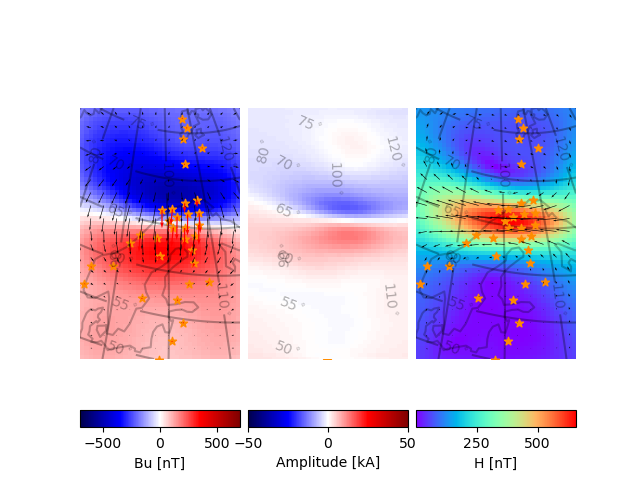

In [31]:
fig= plt.figure()
gs= fig.add_gridspec(2, 3, height_ratios=[1, .05], hspace= 0, wspace=0.05)
mag_ax= fig.add_subplot(gs[0, 0])
mag_cax=fig.add_subplot(gs[1, 0])
amp_ax= fig.add_subplot(gs[0, 1])
amp_cax= fig.add_subplot(gs[1, 1])
cur_ax= fig.add_subplot(gs[0, 2])
cur_cax= fig.add_subplot(gs[1, 2])

for ax in (mag_ax, amp_ax, cur_ax):
    # Adding Coastlines
    for cl in node_grid.projection.get_projected_coastlines(resolution = '110m'):
        ax.plot(*cl, color='black',zorder=1, alpha=.25)
    ax.set_aspect('equal')
    ax.set_xlim(node_grid.xi.min(), node_grid.xi.max())
    ax.set_ylim(node_grid.eta.min(), node_grid.eta.max())
    ax.set_axis_off()
    mlat, mlon= A.geo2apex(node_grid.lat, node_grid.lon, 0)
    clon = ax.contour(node_grid.xi, node_grid.eta, mlon, levels = np.sort(np.r_[-180:180:10]), 
                   colors = 'black', alpha=.3, zorder=1)
    clat = ax.contour(node_grid.xi, node_grid.eta, mlat, levels = np.r_[0:90:5], 
                   colors = 'black', alpha=.3, zorder=1)
    cl= ax.clabel(clon, inline=True, fontsize=10, fmt = lambda x: str(int(x)) + '$^\circ$')
    cl2=ax.clabel(clat, inline=True, fontsize=10, fmt = lambda x: str(int(x)) + '$^\circ$')
    # Magnetometer Locations
    ax.scatter(*node_grid.projection.geo2cube(MagLon, MagLat), marker='*', color='darkorange')

# Magnetometers Measurements
mag_ax.quiver(*node_grid.projection.vector_cube_projection(East, -South, MagLon, MagLat), color='red')
# Modelled Magnetic field
xi, eta, e_xi, e_eta= node_grid.projection.vector_cube_projection(Be, Bn, eval_grid.lon, eval_grid.lat)
xi= xi.reshape(eval_grid.shape)
eta= eta.reshape(eval_grid.shape)
e_xi= e_xi.reshape(eval_grid.shape)
e_eta= e_eta.reshape(eval_grid.shape)
mag_ax.quiver(xi[::3, ::3], eta[::3, ::3], e_xi[::3, ::3], e_eta[::3, ::3], zorder=10)
pc=mag_ax.pcolormesh(eval_grid.xi_mesh, eval_grid.eta_mesh, Bu.reshape(eval_grid.shape)*1e9, cmap='seismic',
                 vmin=-700, vmax=700, zorder=-1)
cbar=fig.colorbar(pc, cax= mag_cax, orientation='horizontal')
cbar.set_label('Bu [nT]')

# SECS Amplitudes
pc2= amp_ax.pcolormesh(node_grid.xi_mesh, node_grid.eta_mesh, Amplitudes.reshape(node_grid.shape)*1e-3, 
                       cmap='seismic', vmin=-50, vmax=50)
cbar2=fig.colorbar(pc2, cax=amp_cax, orientation='horizontal')
cbar2.set_label('Amplitude [kA]')

# Currents
xi, eta, e_xi, e_eta= node_grid.projection.vector_cube_projection(Ce, Cn, eval_grid.lon, eval_grid.lat)
xi= xi.reshape(eval_grid.shape)
eta= eta.reshape(eval_grid.shape)
e_xi= e_xi.reshape(eval_grid.shape)
e_eta= e_eta.reshape(eval_grid.shape)
cur_ax.quiver(xi[::3, ::3], eta[::3, ::3], e_xi[::3, ::3], e_eta[::3, ::3])

# Horizontal Magnetic Field Magnitude
pc3= cur_ax.pcolormesh(eval_grid.xi_mesh, eval_grid.eta_mesh, 
                       (((Be*1e9)**2 +(Bn*1e9)**2)**.5).reshape(eval_grid.shape), cmap='rainbow', zorder=-1)
cbar3= fig.colorbar(pc3, cax=cur_cax, orientation='horizontal')
cbar3.set_label('H [nT]')